In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import jax
import jax.numpy as jnp
from tinyjaxley.modules.comp import Compartment
from tinyjaxley.modules.branch import Branch
# from tinyjaxley.modules.cell import Cell
from tinyjaxley.channels.hh import Na, K, Leak
import matplotlib.pyplot as plt
from tinyjaxley.solvers import fw_euler
import pandas as pd
from diffrax import diffeqsolve, ODETerm, SaveAt, Dopri5
import equinox as eqx
from jax import lax

- recurse into channels -> set and get should work for example
    - submodules should get custom method for each module, i.e. comp.channels -> comp.submodules, branch.comps -> branch.submodules, etc.
- fix `comp.set(("k", "n"), 0.0)` same for `clamp` and `record`
- tests to assert against jaxley

In [3]:
comp = Compartment()
# comp.record("v")
comp.insert(Leak())
comp.insert(Na())
comp.insert(K())
comp.stimulate(lambda t, u: jnp.array([0.01]))

t0 = 0
u0 = comp.all_states
comp.set(("comp", "v"), -70.0)
u0 = comp.init()

In [4]:
ode = ODETerm(comp.vf)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat)

In [5]:
branch = Branch([Compartment()]*2)
# branch.record("v")
branch.insert(Leak())
branch.insert(Na())
branch.insert(K())
branch.comp(0).stimulate(lambda t, u: jnp.array([0.05]))
branch.comp(1).stimulate(lambda t, u: jnp.array([-0.05]))

# t0 = 0
u0 = branch.all_states
# branch.set("v", -70.0)
u0 = branch.init()

In [10]:
branch.show()

comp                              leak                 na             \
       Ra    c     l    r     i     v     e       g    i     e     g    h   
0  5000.0  1.0  10.0  1.0  0.05 -70.0 -54.3  0.0003  0.0  50.0  0.12  0.2   
1  5000.0  1.0  10.0  1.0 -0.05 -70.0 -54.3  0.0003  0.0  50.0  0.12  0.2   

                k                   
     i    m     e      g    i    n  
0  0.0  0.2 -77.0  0.036  0.0  0.2  
1  0.0  0.2 -77.0  0.036  0.0  0.2

In [13]:
ode = ODETerm(branch.vf)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat)

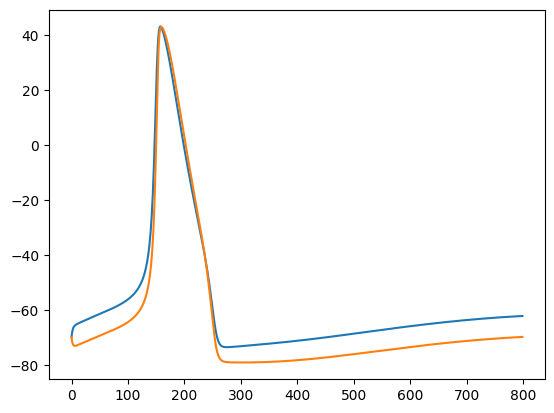

In [14]:
plt.plot(sol.ys[1][0][0]["v"])
plt.plot(sol.ys[1][1][0]["v"])